# Table of Contents

* [1 Overview](#overview) 
* [2 Front Matter](#frontmatter) 
* [3 Introduction](#introduction)
* [n Extending The Work](#extending)

# 1. Overview
<a id = "overview"></a>

This is the semester project for Russ Ballard for GWU DATS6202 Fall 2024 with Dr. Huang. This project offers a sample machine learning pipeline for fitting a convolutional neural net model to a multiclass classification image dataset. The dataset in question is the [Butterfly Image Classification](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification) dataset found on Kaggle, which was originally posted as [Data Sprint 107 - Butterfly Image Classification](https://aiplanet.com/challenges/325/butterfly_identification/overview/about) on aiplanet.

To support model fitting and the testing of parallelized machine learning frameworks these models were fit using a Jupyter Notebook hosted on a Tensorflow container image deployed on the scientist's PC which contains an [EVGA GeForce GTX 1070](https://www.evga.com/products/specs/gpu.aspx?pn=2bf880af-829b-4a21-a591-c1bcb083d93b).

By implementing containerized development locally model training could take place using the GPU's CUDA cores without incurring any cloud related expenses. In th [n Extending The Work](#extending) section we discuss how to further abstract this containerized notebook development framework to be more utile and generally applicable for machine learning modelling work.


# 2. Introduction
<a id = "frontmatter"></a>

In [ ]:
!pip install -r '/tf/requirements.txt'

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 26.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 27.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 28.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 33.7 MB/s eta 0:00:0000:0100:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24551 sha256=c8b6a3b81e99d3426f0cc4a1fe8babc7af19149d1035c2412b49b48a688abfe7
  Stored in directory: /root/.cache/pip/wheels/bd/ce/e8/ff9d9c699514922f57caa22fbd55b0a32761114b4c4acc9e03
Successfully built pydotplus
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7


In [25]:
! apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fontconfig fontconfig-config fonts-dejavu-core fonts-liberation libann0
  libbsd0 libcairo2 libcdt5 libcgraph6 libdatrie1 libdeflate0 libfontconfig1
  libfreetype6 libfribidi0 libgd3 libgraphite2-3 libgts-0.7-5 libgts-bin
  libgvc6 libgvpr2 libharfbuzz0b libice6 libjbig0 libjpeg-turbo8 libjpeg8
  liblab-gamut1 libltdl7 libmd0 libpango-1.0-0 libpangocairo-1.0-0
  libpangoft2-1.0-0 libpathplan4 libpixman-1-0 libpng16-16 libsm6 libthai-data
  libthai0 libtiff5 libwebp7 libx11-6 libx11-data libxau6 libxaw7
  libxcb-render0 libxcb-shm0 libxcb1 libxdmcp6 libxext6 libxmu6 libxpm4
  libxrender1 libxt6 ucf x11-common
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig fontconfig-config fonts-dejavu-core fonts-liberation graphviz
  libann0 libbsd0 libcairo2 libcdt5 libcgraph6 libdatrie

# 2. Introduction
<a id = "introduction"></a>

In [46]:
import pickle

In [ ]:
import keras
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydot
import pydotplus
import seaborn as sns
import tensorflow as tf
import visualkeras
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import plot_model
# importing pretrained models 
# importing pretrained models 
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
warnings.filterwarnings("ignore", category=UserWarning, message=r"Your `PyDataset` class should call `super().__init__\(\*\*kwargs\)`")

## Set Random Seed

In [ ]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set in keras
keras.utils.set_random_seed(random_seed)

# Set random seed in numpy
np.random.seed(random_seed)

In [17]:
#train_dir = 'data/input/butterflies/train'
#test_dir = 'data/input/butterflies/test'
data_dir = 'data/input/butterflies/'
raw_dir = 'data/input/butterflies/raw'
fig_dir = 'figures'

In [8]:
raw_labels_df = pd.read_csv(os.path.join(data_dir,'raw_labels.csv'))

split_train, split_valid = .7, .5

val_df, train_df = train_test_split(raw_labels_df, test_size=split_train, random_state=random_seed)
test_df, val_df = train_test_split(val_df, test_size=split_valid, random_state=random_seed)

In [11]:
train_df.head()

,filename,label
5572,Image_5573.jpg,GREEN CELLED CATTLEHEART
1703,Image_1704.jpg,MONARCH
5862,Image_5863.jpg,QUESTION MARK
1773,Image_1774.jpg,APPOLLO
5709,Image_5710.jpg,BANDED PEACOCK


## Training Augmentation

By passing arguments to ImageDataGenerator we are able to create more robust batches of tensor image data.

Rescaling is an important preprocessing step which transforms the pixel color intensity range from \[0,255\] to \[0,1\]

The rotation range introduces the degree range for random rotations in the image, and shift_range, shear_range, and zoom_range arguments operate similarly```````` 

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=raw_dir,
    x_col='filename',
    y_col='label',
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'
)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=raw_dir,
    x_col='filename',
    y_col='label',
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'
)

Found 4550 validated image filenames belonging to 75 classes.
Found 975 validated image filenames belonging to 75 classes.


In [15]:
#Model CNN 1.1
model_CNN_1_1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(75, activation='softmax')
])

model_CNN_1_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_CNN_1_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 75)             │        38,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,346,635 (100.50 MB)

 Trainable params: 26,346,635 (100.50 MB)

 Non-trainable params: 0 (0.00 B)

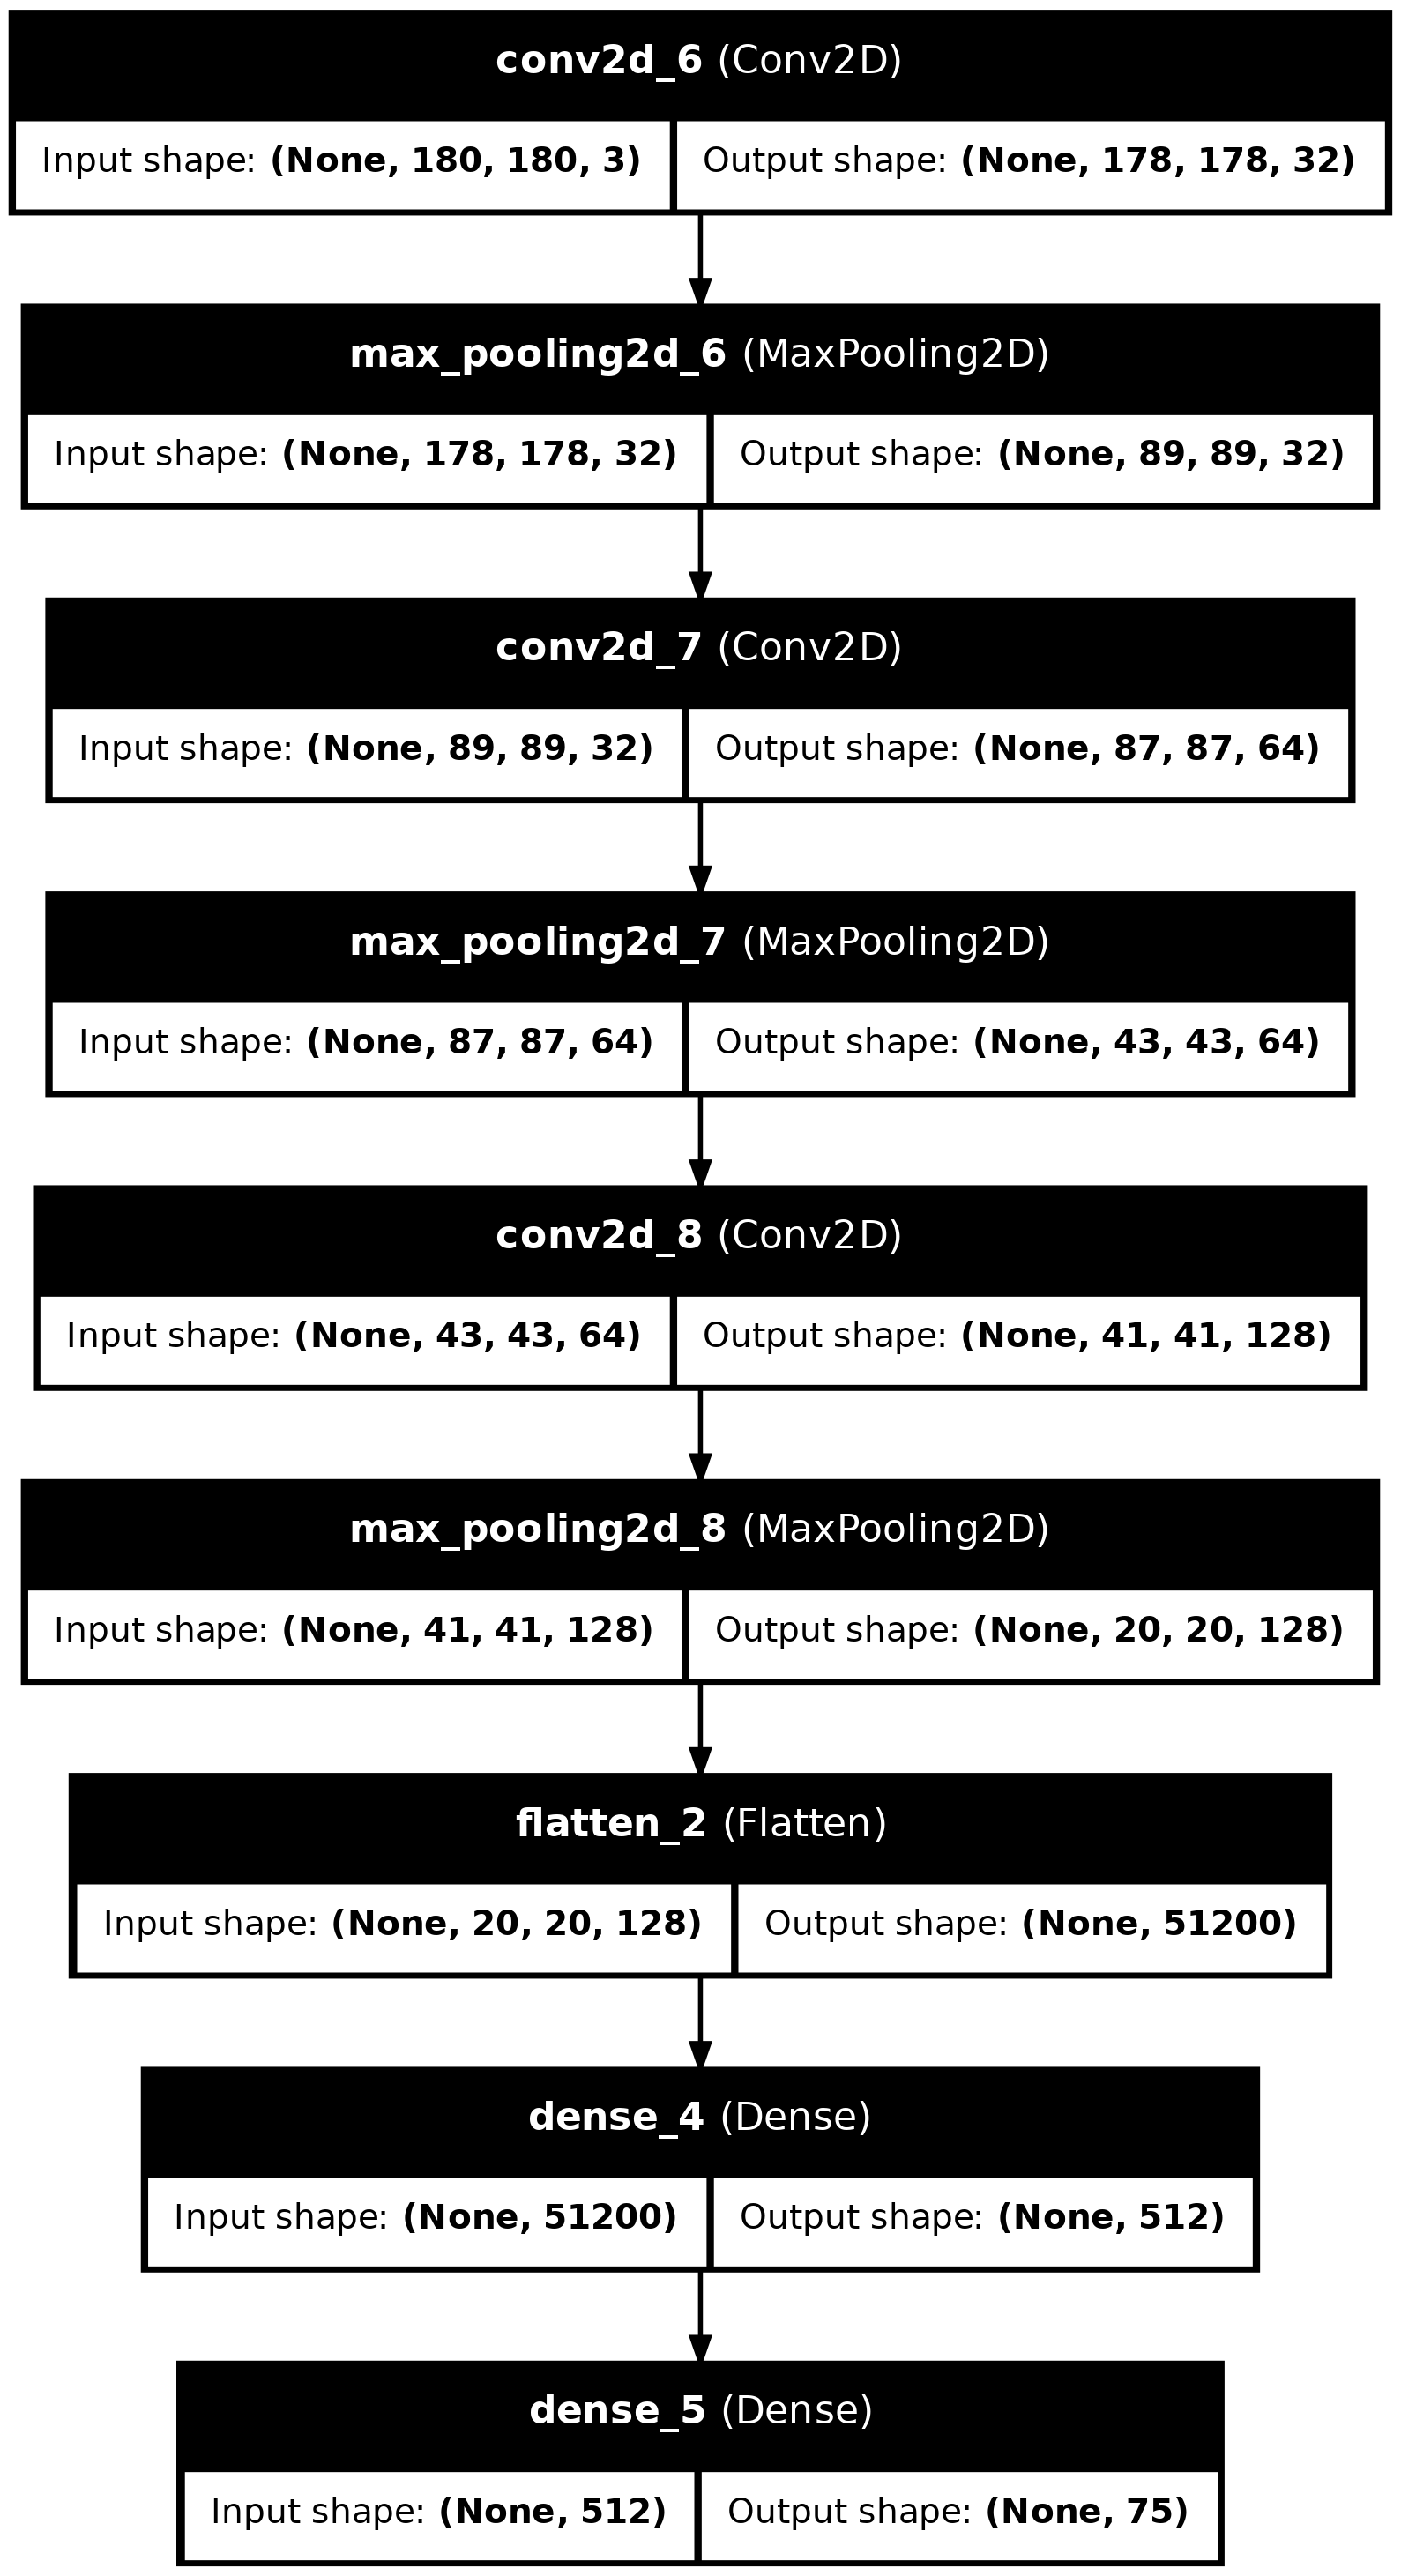

In [27]:
'''Draw Model'''
plot_model(model_CNN_1_1, to_file=os.path.join(fig_dir,'model_CNN_1_1_plot.png'), show_shapes=True, show_layer_names=True)

In [28]:
history_CNN_1_1 = model_CNN_1_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.0376 - loss: 4.3541 - val_accuracy: 0.1896 - val_loss: 3.1279
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step - accuracy: 0.0938 - loss: 3.2599 - val_accuracy: 0.1333 - val_loss: 3.3685
Epoch 3/10


2024-10-20 19:42:32.687035: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-20 19:42:32.754088: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 111s 782ms/step - accuracy: 0.1551 - loss: 3.2746 - val_accuracy: 0.2969 - val_loss: 2.5183
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - accuracy: 0.1875 - loss: 2.6235 - val_accuracy: 0.2000 - val_loss: 2.9511
Epoch 5/10


2024-10-20 19:44:24.840938: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 114s 800ms/step - accuracy: 0.2782 - loss: 2.6159 - val_accuracy: 0.3990 - val_loss: 2.1603
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.4062 - loss: 2.3526 - val_accuracy: 0.4000 - val_loss: 1.8084
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 114s 802ms/step - accuracy: 0.3400 - loss: 2.3552 - val_accuracy: 0.4615 - val_loss: 1.9011
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - accuracy: 0.2188 - loss: 2.1787 - val_accuracy: 0.4667 - val_loss: 1.8749
Epoch 9/10


2024-10-20 19:48:14.276452: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 113s 795ms/step - accuracy: 0.4153 - loss: 2.0647 - val_accuracy: 0.5323 - val_loss: 1.6730
Epoch 10/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.4688 - loss: 1.6946 - val_accuracy: 0.6000 - val_loss: 1.5162


In [ ]:
model_CNN_1_1.save("models/model_CNN_1_1.keras")

In [47]:
with open('models/history/model_CNN_1_1', 'wb') as file_pi:
    pickle.dump(history_CNN_1_1.history, file_pi)

In [ ]:
def plot_loss(modelhist, modelname):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(modelhist.history['accuracy'])
    plt.plot(modelhist.history['val_accuracy'])
    plt.title(f'{modelname} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(modelhist.history['loss'])
    plt.plot(modelhist.history['val_loss'])
    plt.title(f'{modelname} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

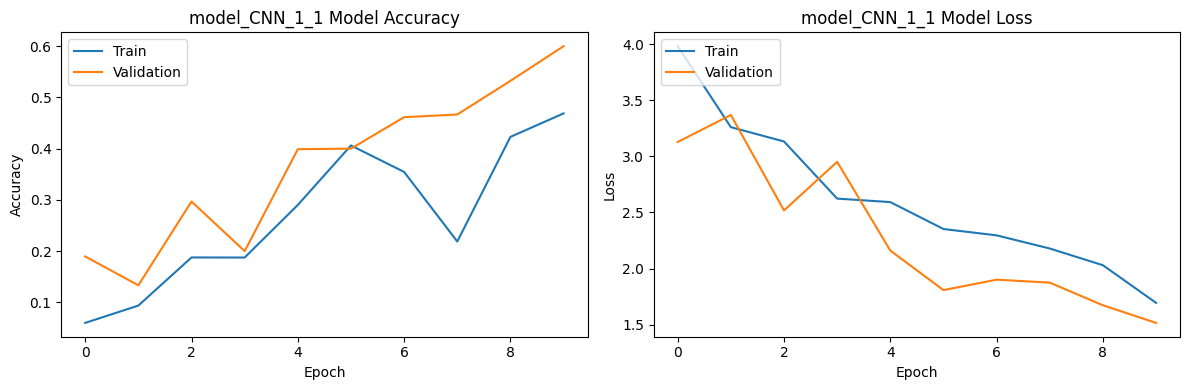

In [41]:
plot_loss(history_CNN_1_1,'model_CNN_1_1')

In [49]:
history_CNN_1_2 = model_CNN_1_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.4764 - loss: 1.8663 - val_accuracy: 0.5927 - val_loss: 1.4949
Epoch 2/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - accuracy: 0.4375 - loss: 1.9949 - val_accuracy: 0.4000 - val_loss: 2.1918
Epoch 3/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 118s 832ms/step - accuracy: 0.5032 - loss: 1.7182 - val_accuracy: 0.5948 - val_loss: 1.4563
Epoch 4/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - accuracy: 0.5312 - loss: 1.4248 - val_accuracy: 0.3333 - val_loss: 1.6915
Epoch 5/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 118s 830ms/step - accuracy: 0.5562 - loss: 1.4902 - val_accuracy: 0.6229 - val_loss: 1.3084
Epoch 6/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step - accuracy: 0.5000 - loss: 1.8249 - val_accuracy: 0.5333 - val_loss: 1.3300
Epoch 7/40


2024-10-21 02:46:54.331435: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 121s 850ms/step - accuracy: 0.5703 - loss: 1.4507 - val_accuracy: 0.6375 - val_loss: 1.2809
Epoch 8/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.6250 - loss: 1.4078 - val_accuracy: 0.7333 - val_loss: 1.1258
Epoch 9/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 120s 842ms/step - accuracy: 0.6075 - loss: 1.3184 - val_accuracy: 0.6208 - val_loss: 1.3130
Epoch 10/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step - accuracy: 0.8125 - loss: 0.9903 - val_accuracy: 0.6000 - val_loss: 0.9739
Epoch 11/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 120s 847ms/step - accuracy: 0.6482 - loss: 1.2121 - val_accuracy: 0.6521 - val_loss: 1.2509
Epoch 12/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - accuracy: 0.5312 - loss: 1.3679 - val_accuracy: 0.5333 - val_loss: 1.9680
Epoch 13/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 120s 847ms/step - accuracy: 0.6377 - loss: 1.1775 - val_accuracy: 0.6615 - val_loss: 1.1777
Epoch 14/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - accuracy: 0.6250 - loss: 1.0275 

2024-10-21 03:03:11.659591: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 122s 858ms/step - accuracy: 0.7199 - loss: 0.9139 - val_accuracy: 0.6906 - val_loss: 1.1611
Epoch 24/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - accuracy: 0.7188 - loss: 0.9006 - val_accuracy: 0.5333 - val_loss: 1.3695
Epoch 25/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 118s 829ms/step - accuracy: 0.7260 - loss: 0.8570 - val_accuracy: 0.7031 - val_loss: 1.1375
Epoch 26/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - accuracy: 0.7812 - loss: 0.8062 - val_accuracy: 0.6000 - val_loss: 1.0351
Epoch 27/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 114s 789ms/step - accuracy: 0.7220 - loss: 0.8958 - val_accuracy: 0.7010 - val_loss: 1.0908
Epoch 28/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.7812 - loss: 0.5917 - val_accuracy: 0.5333 - val_loss: 3.4942
Epoch 29/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 118s 828ms/step - accuracy: 0.7384 - loss: 0.8319 - val_accuracy: 0.7094 - val_loss: 1.0865
Epoch 30/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step - accuracy: 0.7500 - loss: 1.084

In [50]:
with open('models/history/model_CNN_1_2', 'wb') as file_pi:
    pickle.dump(history_CNN_1_2.history, file_pi)

In [ ]:
#to open pickle
with open('/trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)

In [ ]:
#test with dropout layer

In [52]:
#Model CNN 2.1
model_CNN_2_1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(75, activation='softmax')
])

model_CNN_2_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_CNN_2_1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 75)             │        38,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,346,635 (100.50 MB)

 Trainable params: 26,346,635 (100.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_CNN_2_1 = model_CNN_2_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

In [ ]:
model_CNN_2_1.save("models/model_CNN_2_1.keras")
with open('models/history/model_CNN_2_1', 'wb') as file_pi:
    pickle.dump(history_CNN_2_1.history, file_pi)

In [ ]:
plot_loss(history_CNN_2_1,'model_CNN_2_1')

In [70]:
fine_tune_inception1_2 = keras.models.load_model('models/fine_tune_inception1_2.keras')

In [76]:
#Test Holdout Eval

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=raw_dir,
    x_col='filename',
    y_col='label',
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'
)
scores = model.evaluate(test_generator)

Found 975 validated image filenames belonging to 75 classes.


31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 337ms/step - accuracy: 0.9382 - loss: 0.2455


In [ ]:
train_df = pd.read_csv(f'{data_dir}Training_set.csv')
test_df = pd.read_csv(f'{data_dir}Testing_set.csv')

In [34]:
train_df.head(10)

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART
5,Image_6.jpg,CAIRNS BIRDWING
6,Image_7.jpg,GREEN CELLED CATTLEHEART
7,Image_8.jpg,EASTERN DAPPLE WHITE
8,Image_9.jpg,BROWN SIPROETA
9,Image_10.jpg,RED POSTMAN


/tmp/ipykernel_31268/2305801828.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


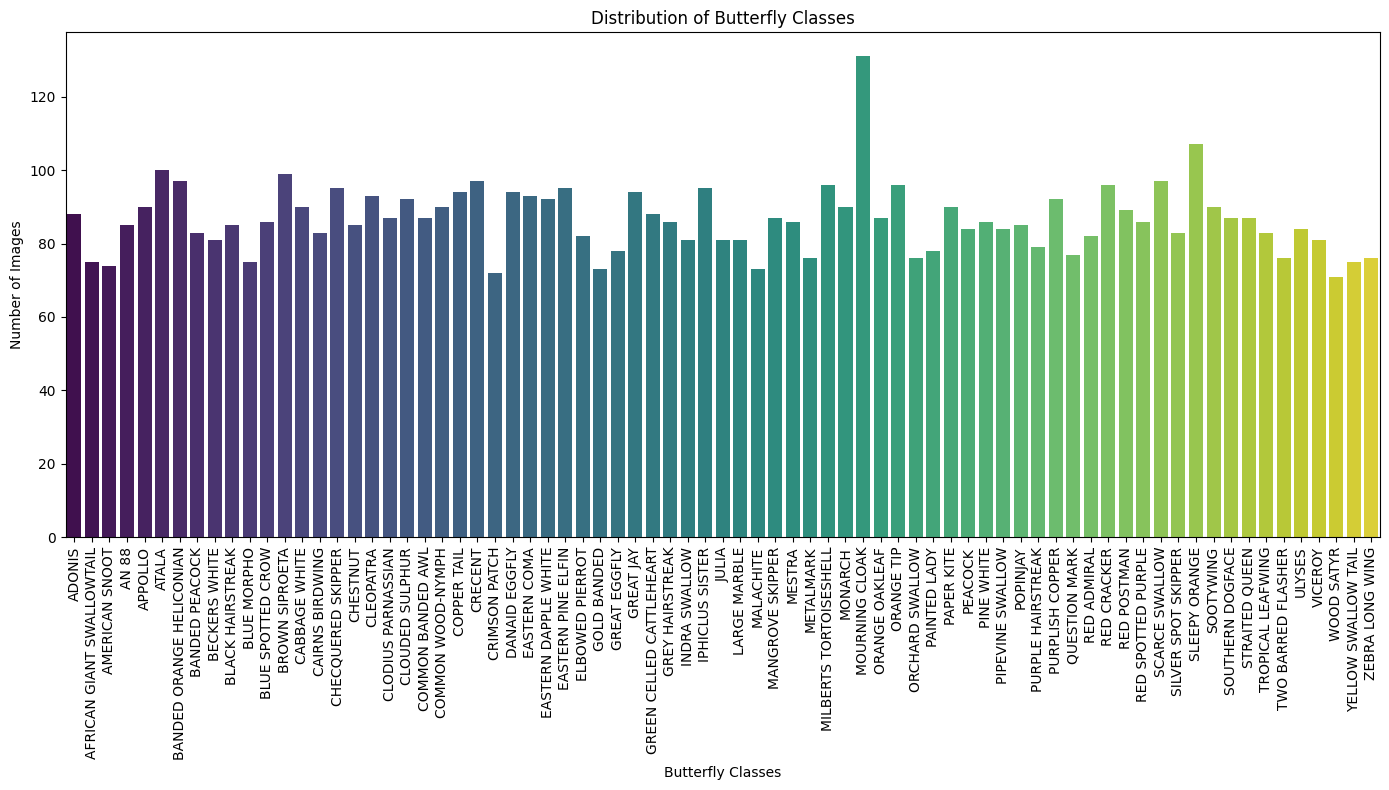

In [35]:
#delete?
class_counts = train_df['label'].value_counts().sort_index()
class_counts_percent = train_df['label'].value_counts(normalize=True)*100


plt.figure(figsize=(14, 8))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Butterfly Classes')
plt.xlabel('Butterfly Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

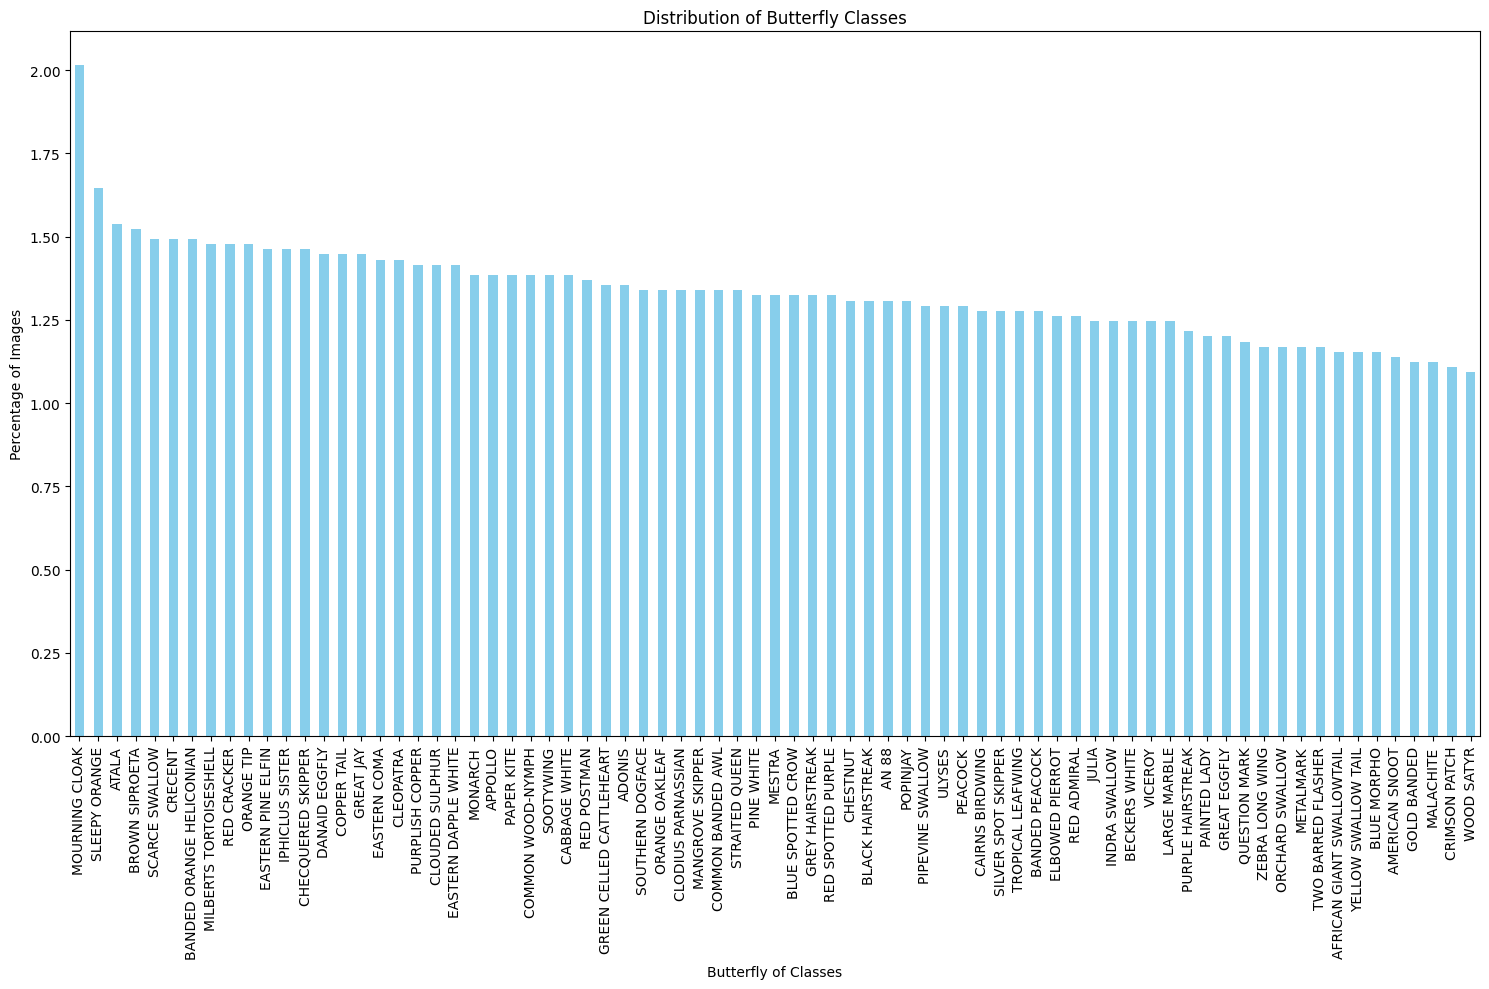

In [36]:
fig2 = plt.figure(figsize = (15,10))
class_counts_percent.plot(kind='bar', color='skyblue')
plt.title("Distribution of Butterfly Classes")
plt.xlabel("Butterfly of Classes")
plt.ylabel("Percentage of Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

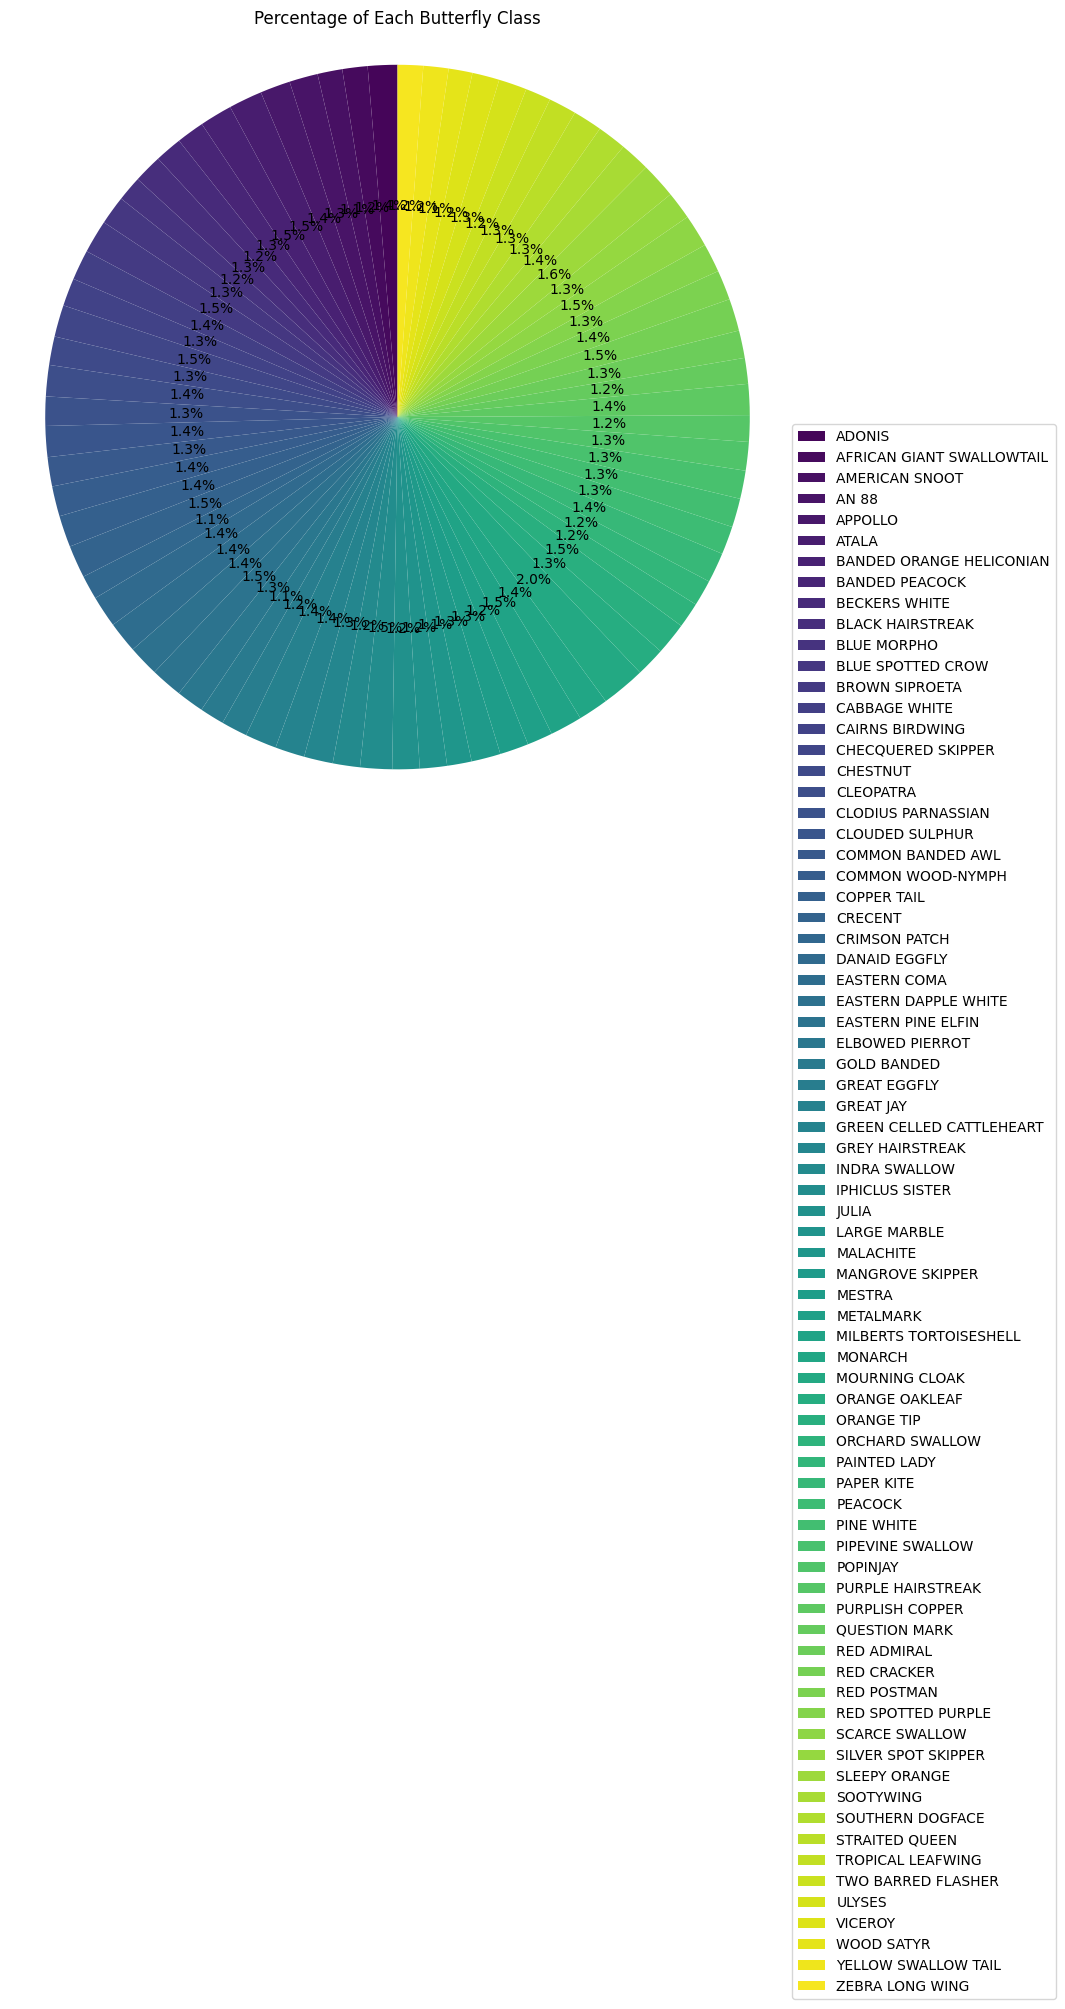

In [37]:
#delete?
colors = sns.color_palette("viridis", len(class_counts))
class_counts = train_df['label'].value_counts().sort_index()


plt.figure(figsize=(10, 10))
plt.pie(class_counts.values, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Each Butterfly Class')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(class_counts.index, loc="best", bbox_to_anchor=(1, 0.5))
plt.show()

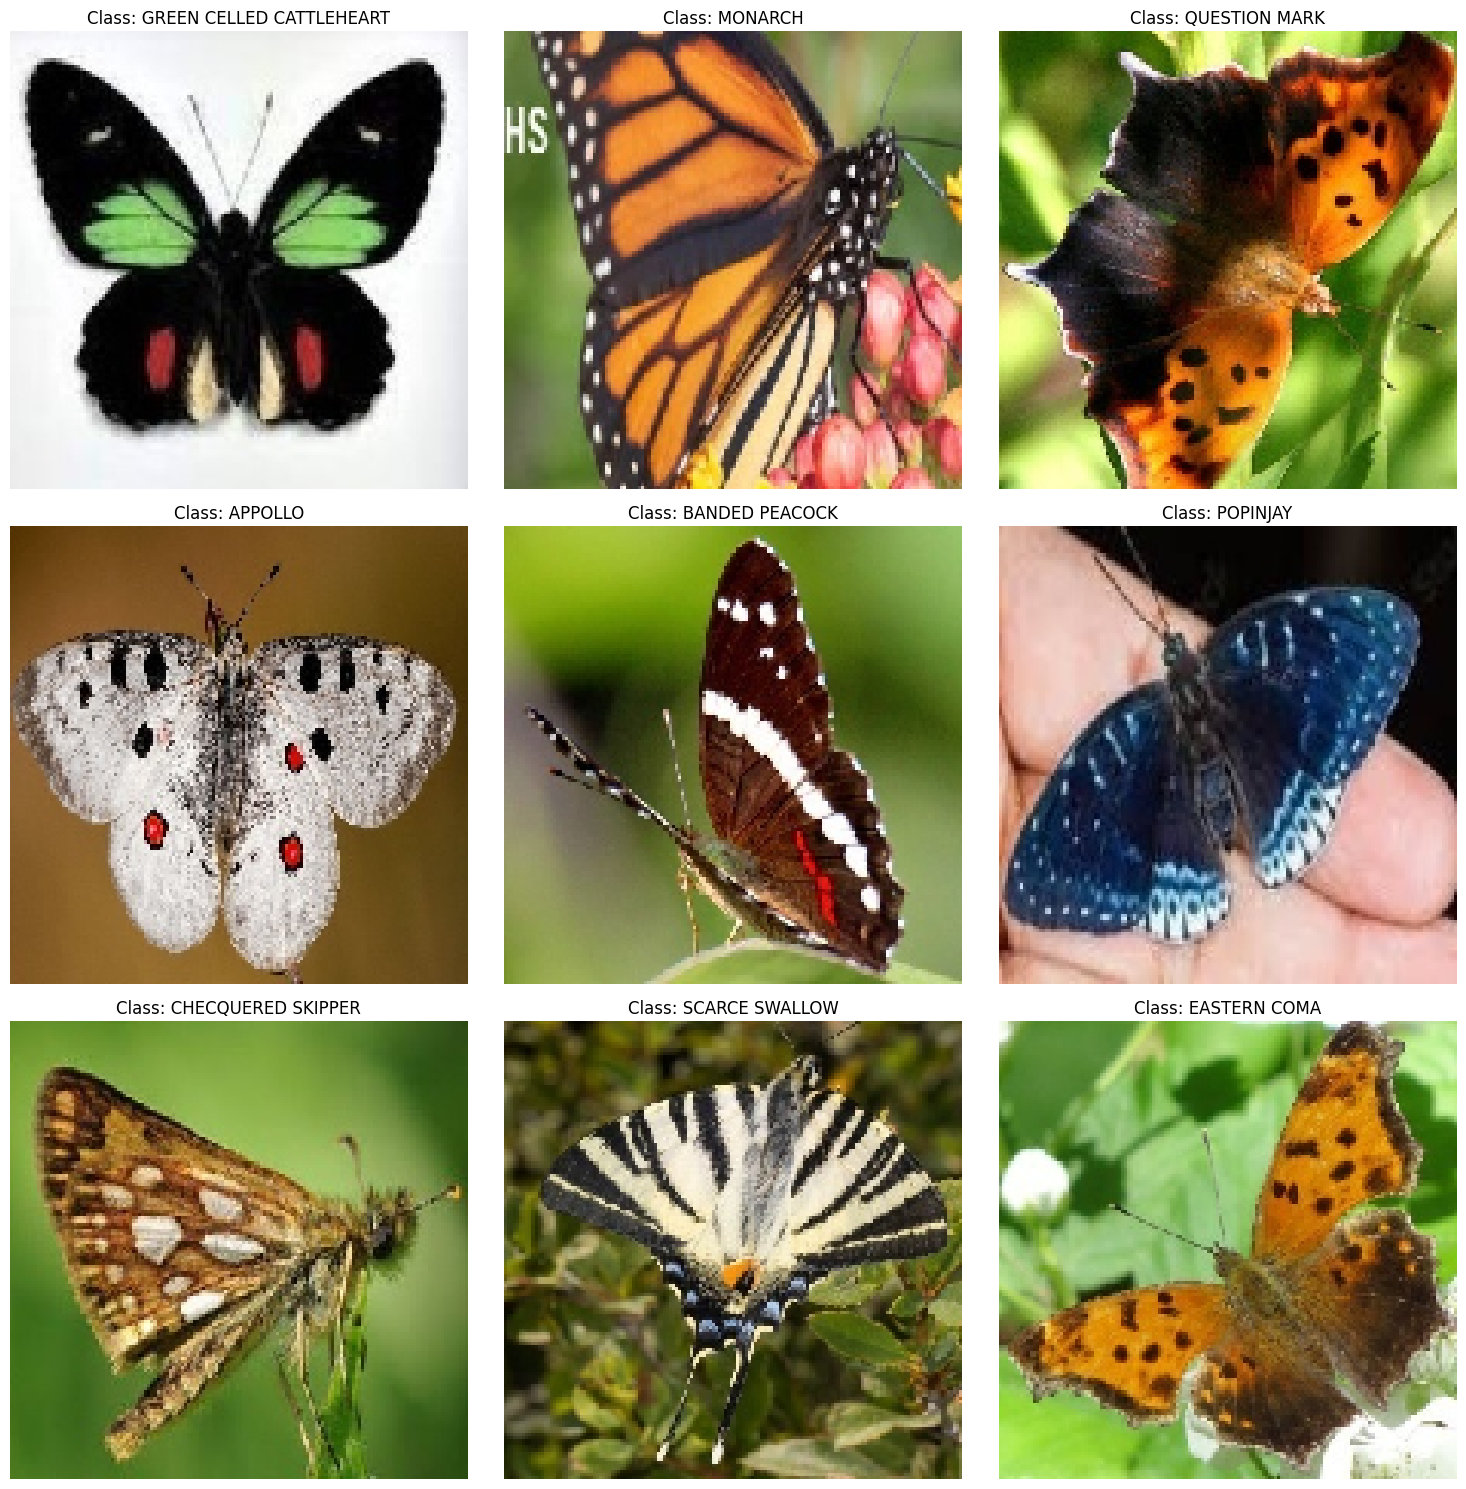

In [38]:
sample_images = train_df.sample(9, random_state=42)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(train_dir, row['filename'])
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    
    ax = axes[i // 3, i % 3]
    ax.imshow(img_array)
    ax.set_title(f"Class: {row['label']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'
)

In [ ]:
train_generator

In [ ]:
model_CNN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(75, activation='softmax')
])

model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_CNN.summary()

In [ ]:
history = model_CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
val_images, val_labels = next(val_generator)

pred_labels = model_CNN.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = val_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(val_images, true_labels, pred_labels, class_names, num_images=9)

In [ ]:
#Inception Model
#Generators
#train_generator, val_generator

base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
# Freeze the layers except the last few layers
for layer in base_model.layers[:-18]:
    layer.trainable = False

In [ ]:


model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(75, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005), 
    metrics=['accuracy']
)

model.summary()

In [ ]:
fine_tune_inception1_2 = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    )

In [ ]:
model.save("models/fine_tune_inception1_2.keras")


In [20]:
fine_tune_inception1_2 = keras.models.load_model('models/fine_tune_inception1_2.keras')

In [9]:
# visulization function for Models
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    

In [10]:
def print_final_acc(history):
    final_acc_train = round(history.history['accuracy'][-1],4)
    final_acc_val = round(history.history['val_accuracy'][-1],4)
    print(f"Training Accuracy: {final_acc_train}\nValidation Acuracy:{final_acc_val}")

In [13]:
print_final_acc(fine_tune_inception1_2)

AttributeError: 'Sequential' object has no attribute 'history'

In [ ]:
visualize(fine_tune_inception1_2)

In [ ]:
import pydot

In [21]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
'''Draw Model'''
plot_model(fine_tune_inception1_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

AttributeError: module 'pydotplus' has no attribute 'PydotException'

In [ ]:
plot_model(fine_tune_inception1_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

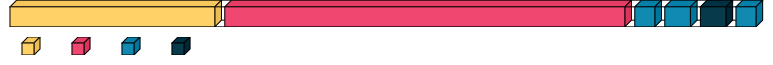

In [28]:
visualkeras.layered_view(model, legend = True)

In [20]:
from PIL import ImageFont

In [ ]:
import visualkeras
font = ImageFont.truetype(font="/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf",size = 12)
visualkeras.layered_view(model, legend = True, font=font)

In [21]:
font = ImageFont.truetype(font="/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf",size = 12)

In [ ]:
!fc-list